# LIGO tutorial: find an inspiral

https://gwosc.org/tutorial06/

## Read in the data and template

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import h5py
import matplotlib.mlab as mlab

In [2]:
fs = 4096
dataFile = h5py.File('data_w_signal.hdf5', 'r')
data = dataFile['strain/Strain'][...]
dataFile.close()
time = np.arange(0, 16, 1./fs)

# -- Read the template file (1 second, sampled at 4096 Hz)
templateFile = h5py.File('template.hdf5', 'r')
template = templateFile['strain/Strain'][...]
temp_time = np.arange(0, template.size / (1.0*fs), 1./fs)
templateFile.close()

Text(0.5, 1.0, 'Template')

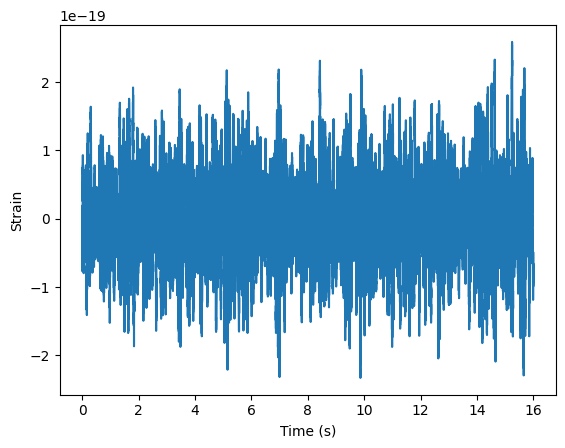

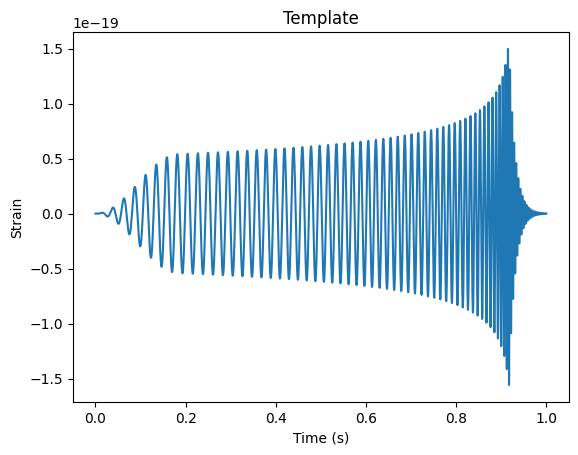

In [3]:
plt.figure()
plt.plot(time,data)
plt.xlabel('Time (s)')
plt.ylabel('Strain')

plt.figure()
plt.plot(temp_time, template)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Template')

/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


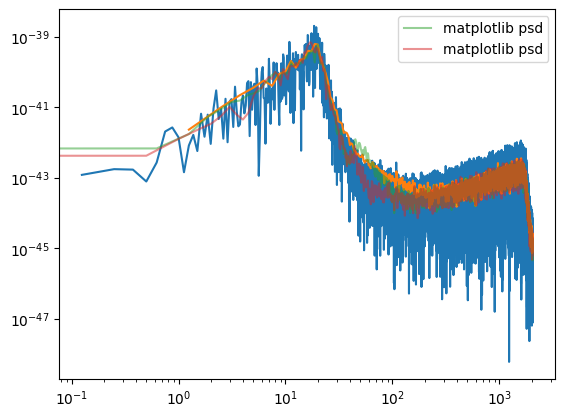

In [4]:
data1 = np.copy(data[len(data)//2:])

N = len(data1)

# Try to understand the psd calculations they are doing
fft_d = np.fft.fft(data1)
psd_d = 2 * np.conjugate(fft_d) * fft_d  / (N*fs)
f_d = np.fft.fftfreq(len(data1), d = 1./fs)
plt.loglog(f_d[f_d>0], psd_d[f_d>0])

N1 = N//10
for i in range(10):
    fft_d = np.fft.fft(data1[i*N1:(i+1)*N1])
    if i == 0:
        psd_d = 2 * np.conjugate(fft_d) * fft_d  / (N1*fs) / 10
    else:
        psd_d += 2 * np.conjugate(fft_d) * fft_d  / (N1*fs) / 10

f_d = np.fft.fftfreq(N//10, d = 1./fs)
plt.loglog(f_d[f_d>0], psd_d[f_d>0])

Pxx, freqs = mlab.psd(data, Fs=fs, NFFT=len(data)//10)
plt.loglog(freqs, Pxx, label='matplotlib psd', alpha=0.5)

Pxx, freqs = mlab.psd(data, Fs=fs, NFFT=2*fs)
plt.loglog(freqs, Pxx, label='matplotlib psd', alpha=0.5)

plt.legend()

## Bandpass filter

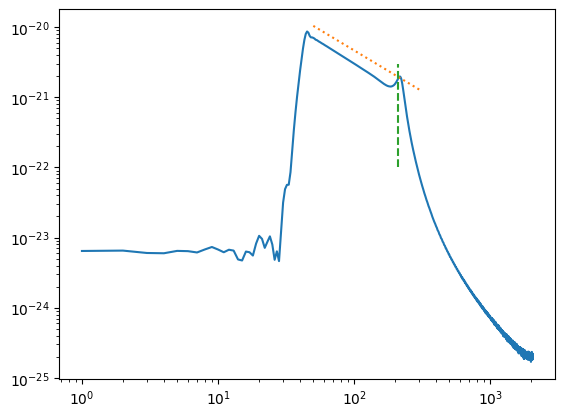

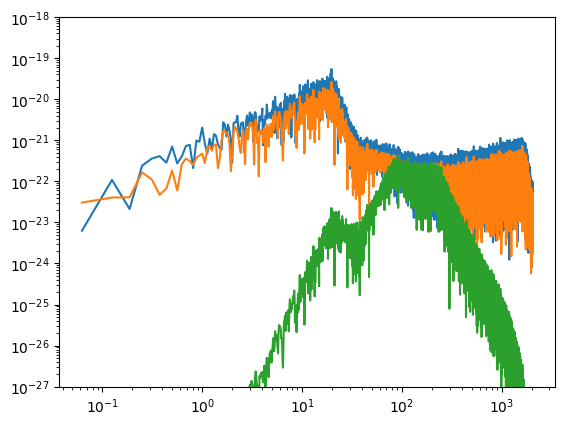

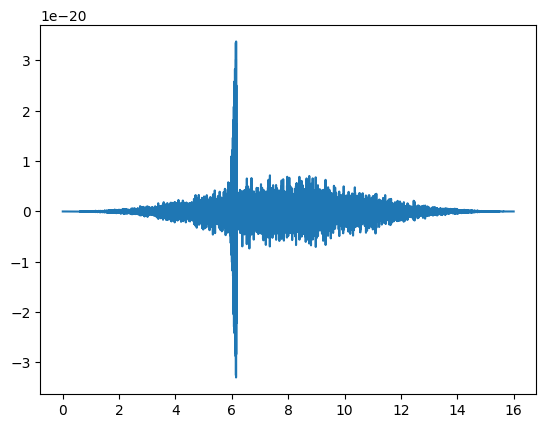

In [5]:
def asd(fft):
    return np.sqrt(2* np.conjugate(fft) * fft / (fs*len(fft)))

# Template ASD
fft_t = np.fft.fft(template)
asd_t = asd(fft_t)
f_t = np.fft.fftfreq(len(template), d = 1./fs)
plt.plot(f_t[f_t>0], asd_t[f_t>0])
plt.xscale('log')
plt.yscale('log')

# Plot the -7/6 slope for the inspiral and 210 Hz location of the bump
f = np.linspace(50,300,100)
plt.plot(f, 1e-18*f**(-7/6),":")
plt.plot((210,210),(1e-22,3e-21), "--")
plt.show()

# Data ASD
fft_d = np.fft.fft(data)
asd_d = asd(fft_d)
f_d = np.fft.fftfreq(len(data), d = 1./fs)
plt.clf()
plt.plot(f_d[f_d>0], asd_d[f_d>0])

# with Blackman window
window = np.blackman(len(data))
data1 = data * window
fft_d1 = np.fft.fft(data1)
asd_d1 = asd(fft_d1)
f_d1 = np.fft.fftfreq(len(data1), d = 1./fs)
plt.plot(f_d1[f_d1>0], asd_d1[f_d1>0])

# ASD after applying a low pass filter between 80 and 250 Hz
(B,A) = sig.butter(4, [80/(fs/2.0), 250/(fs/2.0)], btype='pass')
data_pass = sig.lfilter(B, A, data1)
fft_d2 = np.fft.fft(data_pass)
asd_d2 = asd(fft_d2)
f_d2 = np.fft.fftfreq(len(data_pass), d = 1./fs)
plt.plot(f_d2[f_d2>0], asd_d2[f_d2>0])

plt.xscale('log')
plt.yscale('log')
plt.ylim((1e-27, 1e-18))
plt.show()

# time-series after filter
plt.plot(time, data_pass)
plt.show()

## Time domain cross-correlation

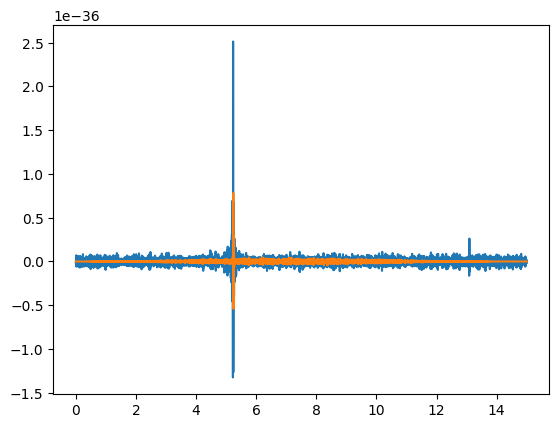

In [6]:
correlated_raw = np.correlate(data, template, 'valid')
correlated_passed = np.correlate(data_pass, template, 'valid')
plt.figure()
plt.plot(np.arange(0, (correlated_raw.size*1.)/fs, 1.0/fs),correlated_raw)
plt.plot(np.arange(0, (correlated_passed.size*1.)/fs, 1.0/fs),correlated_passed)
#plt.xlim((4,6))
plt.show()

## Matched filter

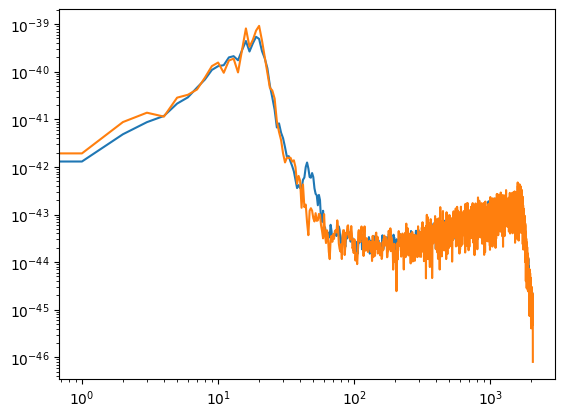

[-2048.     -2047.9375 -2047.875  ...  2047.8125  2047.875   2047.9375]
[0.000e+00 1.000e+00 2.000e+00 ... 2.046e+03 2.047e+03 2.048e+03]
[0.00023865 0.00035458 0.00047051 ... 0.00023865 0.00023865 0.00023865]


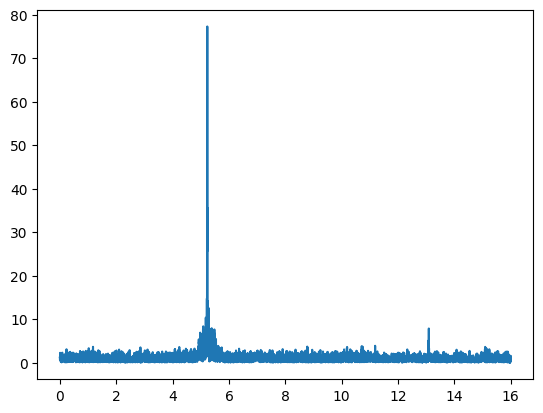

In [7]:
data_fft=np.fft.fft(data)

zero_pad = np.zeros(data.size - template.size)
template_padded = np.append(template, zero_pad)
template_fft = np.fft.fft(template_padded)

# -- Calculate the PSD of the data
power_data_all, freq_psd_all = mlab.psd(data, Fs=fs, NFFT=fs)
power_data, freq_psd = mlab.psd(data[12*fs:], Fs=fs, NFFT=fs)

plt.clf()
plt.plot(freq_psd_all, power_data_all)
plt.plot(freq_psd, power_data)
plt.xscale('log')
plt.yscale('log')
plt.show()

# -- Interpolate to get the PSD values at the needed frequencies
datafreq = np.fft.fftfreq(data.size)*fs
power_vec = np.interp(datafreq, freq_psd, power_data)

print(np.fft.fftshift(datafreq))
print(freq_psd)
print(power_vec/max(power_vec))

# -- Calculate the matched filter output
optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)

# -- Normalize the matched filter output
df = np.abs(datafreq[1] - datafreq[0])
sigmasq = 2*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

# -- Plot the result
plt.clf()
plt.plot(time, SNR)
plt.show()



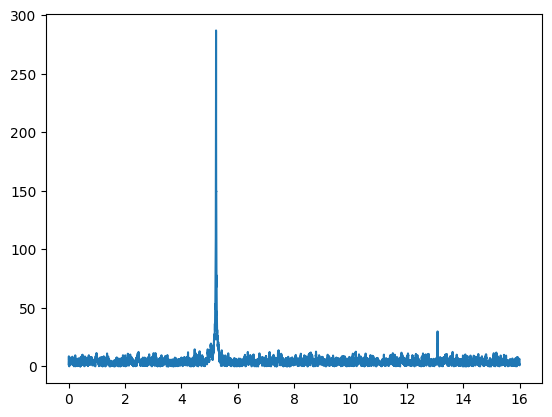

In [8]:

def psd(data, f_d):
    fft = np.fft.fft(data[12*fs:])
    psd = 2 * np.conjugate(fft) * fft / (fs * len(fft))
    freq = np.fft.fftfreq(len(data[12*fs:]), d = 1/fs)
    return np.interp(f_d, freq, psd)

fft_d = np.fft.fft(data)
fft_t = np.fft.fft(template, len(data))
f_d = np.fft.fftfreq(len(data), d = 1/fs)
psd_d = psd(data, f_d)

# -- Calculate the matched filter output
optimal = 2 * fft_d * fft_t.conjugate() / psd_d
optimal_time = np.fft.ifft(optimal)

# -- Normalize the matched filter output
df = np.abs(f_d[1] - f_d[0])
sigmasq = 2 * -(fft_t * fft_t.conjugate() / psd_d).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

# -- Plot the result
plt.figure()
plt.plot(time, SNR)
plt.show()